# Udacity Self Driving Nanodegree 4. Project "Advnaced Lane Finding"

## Project submission

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

[//]: # (Image References)

[image1]: ./undistortion_example.jpg "Undistorted"
[image2]: ./undistortion_example_2.jpg "Undistorted2"
[image3]: ./image_warped.jpg "Warped"
[image4]: ./binary_image.jpg "Binary"
[image5]: ./polylanes.png "Binary"
[image6]: ./curverad.jpg "Curverad"
[image7]: ./test_done2.jpg "test1"
[image8]: ./test_done3.jpg "test2"

### Camera calibaration.

In case to calibrate video camera so we could extract undistorted images from input stream we need to take pictures of object where we can detect distance between multiple elements. For very good example of such object is ChessBoard. We simply count corners inside it and then by taking multiple pictures from different distances and angles we can observe how distance between corners are changing therefore calculate distortion. For that we use well written OpenCV functions : findChessboardCorners() for findind cornerts in image, and calibrateCamera() to calibrate camera from object points provided from previous function. And then using cameraMatrix and distortion coefficients we can undistort images again using openCV function undistort().

On the left Original image and on the left Undistorted mage.

![alt text][image1]

### Code structure

#### Classes : 

* Utils : some useful functions
* CameraCalibration : calibrate camera and correct distortion
* binary_image : apply color masks and sobel filters so lanes could be detected
* lane_finding : perspective transfromations, lane finding and displaying

#### Function :

* Function which is used to find lanes for image stream. Before function previous classes must be initilized.

### Pipeline

#### 1. Correct Image distortion.

Using previously calculated cameraMatrix and distortion coefficients we can undistort every input image from video. For this we have created class CameraCalibration with two usefull functions :

1. calibrate : calirate camera based on input images
2. undistort : undistort input image based on calculated cameraMatrix and distortion coefficient values.

Usage :

```
C = CameraCalibration()
chess_h = 6
chess_w = 9
C.calibrate('camera_cal/calibration', chess_h, chess_w)

im = cv2.cvtColor(cv2.imread('camera_cal/calibration1.jpg'), cv2.COLOR_BGR2RGB)
im_undistorted = C.undistort(im)
```

![alt text][image2]

#### 2. Perspective tranformations.

Before color masks and sobel filters we first need to create just right image to work with later. We need to apply perspective transformation so we could observe lanes like from birds eye. This gives us better understanding about curvature of lanes. Also I did cut buttom of image because of don't need front of car to be visible in image.

To apply perspective transofrmations we use lane_finding class warper function. When this class is initilized then tranformation and inverse transformation coefficients are created. Later those coefficients used to change perspective from original image to birds eye view and vice verse when we need to display lanes.

I used static source and destindation coordinates rather then dynamic because it worked just finde for project video.

Usage :

```
imshape = (720, 1280)
# Cut image a little bit
cut_y = 0.985

# source points for Perspective Transformation
src = np.float32([[imshape[1]*0.47, imshape[0]*0.63],
                 [imshape[1]*0.16, imshape[0]],
                 [imshape[1]*0.93, imshape[0]],
                 [imshape[1]*0.56, imshape[0]*0.63]])

# Destination points for Perspective transformation
dst = np.float32([[(imshape[1] * 0.2), 0],
                 [(imshape[1] * 0.2), imshape[0]],
                 [(imshape[1] * 0.88), imshape[0]],
                 [(imshape[1] * 0.88), 0]])

L = lane_finding(src, dst)
# Creater warped image after Perspective transformation
warped_im = L.warper(im_undistorted)
```
![alt text][image3]

#### 3. Color masks and sobel filter 

To create binary image usefull for further computations I extracted yellow and white lines using color masks from HSV channels and then applied sobel in x and y directions and computed magnitude for that for S and L channels from HSL channel image with kernel_size=27 to make image more smoother. HSV image provided good properties to extract exact those colors I needed however S and L channels seemed to work best for detecting lines.

Usage :
```
kernel_size = 27
# Iterval for color mask, for yellow color low and high values
yellow_hsv_low  = np.array([0, 65, 165])
yellow_hsv_high = np.array([40, 255, 255])

# Iterval for color mask, for white color low and high values
white_hsv_low  = np.array([18, 0, 170])
white_hsv_high = np.array([255, 80, 255])

B = binary_image(kernel_size = kernel_size)

B.convert_HSV(warped_im)
yellow = B.color_mask(yellow_hsv_low, yellow_hsv_high)
white = B.color_mask(white_hsv_low, white_hsv_high)

# create color mask combo binary image
color_combo = np.zeros_like(yellow)
color_combo[(yellow == 1) | (white == 1)] = 1

B.convert_HLS(warped_im)
warped_sobel_L, warped_sobel_S = B.sobel_mask((90, 160), (90, 160))

# create sobel filter mask combo binary image
sobel_combo = np.zeros_like(warped_sobel_L)
sobel_combo[(warped_sobel_L == 1) | (warped_sobel_S == 1)] = 1

# Combine color binary image together with sobel filter binary image 
combo = np.zeros_like(sobel_combo)
combo[(sobel_combo == 1) | (color_combo == 1)] = 1
```

![alt text][image4]

#### 4. Identify lane-line pixels and fit their positions with a polynomial

Idea behind identifying lane-lines is simple. Wo compute histogram over binary image which simply means that we calculate number of pixels with value of 1 and then we clearly can see where our lines are placed. To be more assuring I apply savgol_filter with window size of 27 and polynomial size of 3 which gives as smooth version of histogram and hides some unexpected thin lines.

Then to fit their position we use slinding window can calculate where are most pixels and calculate mean position. When we got necesarry position points we apply second order polynomial.

We also use function called next_fit() in lane_finding class which basicaly calculate same values for next image based on previous values because we know where the lines are and we don't need to go blind searching with windows.

Usage :

```
L = lane_finding(src, dst)
L.load_images(combo, im_undistorted)
L.blind_polyfit()
_, left_fit, right_fit, ploty = L.line_points()
```

![alt text][image5]

#### 5. Radius of curvature and car position

In case to calculate Radius of curvature we first need some conversation between pixel space and real space :

```
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
```

When we got proper conversation then we can fit new polynomials to x and y world space and then using those coefficients using formula it is possible to calculate actual Radius.

Then we simply calculated car posito

Usage :

```
L.curvature()
print('Left', L.left_curverad, 'Right', L.right_curverad)
```

![alt text][image6]

#### 5. Draw lanes
So the last step is actually put all previous together and draw actual lanes.

So full pipeline looks like this :

#### First we initilize global variables for pipeline

```
# Global values for whole pipeline
imshape = (720, 1280)
im_calib_path = 'camera_cal/calibration'
chess_h = 6
chess_w = 9
kernel_size = 27

# Cut image a little bit
cut_y = 0.985

# Iterval for color mask, for yellow color low and high values
yellow_hsv_low  = np.array([0, 65, 165])
yellow_hsv_high = np.array([40, 255, 255])

# Iterval for color mask, for white color low and high values
white_hsv_low  = np.array([18, 0, 170])
white_hsv_high = np.array([255, 80, 255])

# source points for Perspective Transformation
src = np.float32([[imshape[1]*0.47, imshape[0]*0.63],
                 [imshape[1]*0.16, imshape[0]],
                 [imshape[1]*0.93, imshape[0]],
                 [imshape[1]*0.56, imshape[0]*0.63]])

# Destination points for Perspective transformation
dst = np.float32([[(imshape[1] * 0.2), 0],
                 [(imshape[1] * 0.2), imshape[0]],
                 [(imshape[1] * 0.88), imshape[0]],
                 [(imshape[1] * 0.88), 0]])


# Initilize class values
U = Utils()
B = binary_image(kernel_size = kernel_size)
L = lane_finding(src, dst)
C = CameraCalibration()

# Calibration camera
C.calibrate(im_calib_path, chess_h, chess_w)
```

#### Define pipeline

```
def pipeline(im):
    """Pipeline function.
    
    Input : Image
    Output : Image with lanes found + binary image on the right
    
    """
    
    # Undistort image
    im_undistorted = C.undistort(im)
    
    # Cut little bit of buttom which is not needed
    im_undistorted = im_undistorted[0 : int(im_undistorted.shape[0] * cut_y), :]
    
    # Creater warped image after Perspective transformation
    warped_im = L.warper(im_undistorted)
    
    B.convert_HSV(warped_im)
    yellow = B.color_mask(yellow_hsv_low, yellow_hsv_high)
    white = B.color_mask(white_hsv_low, white_hsv_high)
    
    # create color mask combo binary image
    color_combo = np.zeros_like(yellow)
    color_combo[(yellow == 1) | (white == 1)] = 1

    B.convert_HLS(warped_im)
    warped_sobel_L, warped_sobel_S = B.sobel_mask((90, 160), (90, 160))

    # create sobel filter mask combo binary image
    sobel_combo = np.zeros_like(warped_sobel_L)
    sobel_combo[(warped_sobel_L == 1) | (warped_sobel_S == 1)] = 1
    
    # Combine color binary image together with sobel filter binary image 
    combo = np.zeros_like(sobel_combo)
    combo[(sobel_combo == 1) | (color_combo == 1)] = 1

    L.visual(['binary'])
    
    # Load images to lane finding class
    L.load_images(combo, im_undistorted)
    
    # Run and return images with lanes found

    return L.run()
```

#### Run on video. Note that Need to initilize lane_finding class before start using pipeline otherwise pipeline will.

```
#  use previously saved values
L = lane_finding(src, dst)
output = 'project_video_done.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)
```

![alt text][image7]
![alt text][image8]

### Discussion

#### 1. Pipeline works just ok with project video but it has issues with challenge video because of pre-defined Region of Interest (for perspective transformations) which is not exactly same for challenge video. So here are two options. Either we find ROI which is good for both secenarios or we calculate dynamic ROI based on car position.

#### 2. Also there could be better use of color and sobel masks I used. They work just fine for project video but for some scnearios where there are shadows, different lightening it will fail. Here I tool benefits only from calculating Magniutude but also Direction or abs sobel could be calculated.

#### 3. To work in real life scenarios I should work much more to this project. Computer vision is fun and absolutely needed to solve self driving issues however I would try to solve this issue with neural nets and path planning rather than defining lanes because sometimes there even aren't any lanes on road.

### Submission includes

* link to video : https://youtu.be/z03N9eTDklU
* advnanced_lane_finding.ipynb : Include code and Writeup
* project_video_done.mp4 : Project video with lanes found and binary image output on the right
* test_images and camera_cal images folder from original repository
* images necesarry for this writeup

In [1]:
# All imports for following writeup
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from matplotlib import gridspec
import math
from scipy.signal import savgol_filter
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
class Utils(object):
    """Some utils useful during work."""
    
    def pim(self, images, titles=None, cmap='gray'):
        """Display one or more images in one row without blocking.
        
        Input :
            images : list of images as numpy arrays
            titles : list of title strings for each image. Default : None
            cmap : color map for showing image. Default : gray
        
        Output :
            Plot all images in one row with plt.show(block=False)
        """
        
        if type(images) != list:
            return None
        
        N = len(images)
        
        cols = len(images)
        rows = int(math.ceil(N / cols))
        
        if titles is None:
            titles = ['Image'] * N

        gs = gridspec.GridSpec(rows, cols)
        fig = plt.figure(figsize=(14, 8))
        for n in range(N):
            ax = fig.add_subplot(gs[n])
            ax.imshow(images[n], cmap=cmap)
            ax.set_title(titles[n])

        gs.tight_layout(fig)
        plt.show(block=False)
    
    def basic_info(self, data, t = ''):
        """Basic information about numpy array.
        
        1. Data type
        2. Numpy array shape
        3. Min value
        4. Max value
        5. Mean value
        6. STD value
        
        Automaticaly prints it out.
        """
        
        print(t, end=' ')
        data_min = np.min(data)
        data_max = np.max(data)
        data_mean = np.mean(data)
        data_std = np.std(data)
        print('{} {} Min {} Max {} Mean {} std {}'.format(data.dtype,
                                                          data.shape,
                                                          round(data_min, 4),
                                                          round(data_max, 4),
                                                          round(data_mean, 4),
                                                          round(data_std, 4)))

In [3]:
class CameraCalibration(object):
    """Calibrition class to calibrate and undistort camera images using chess template.
    
    1. Run calibrate function to calibrate camera
    2. Run undistort function for undistortion
    """
    
    def calibrate(self, prefix, chess_hight, chess_width, compression='jpg'):
        """
        Load images taken by camera to be calibrated.
        
            prefix : path + common prefix for names of images
            compression : image format. Default : jpg
        
        Find chess points using cv2 findChessboardCorners.
            
            chess_hight : points inside chess board to be find vertically
            chess_width : points inside chess board to be find horizontally
        """
        
        # Load all image full paths from folder.
        im_paths = glob.glob(prefix + '*.' + compression)
        objpoints, imgpoints, img_size = self.find_chess_board_corners(im_paths, chess_hight, chess_width)
        
        # Do camera calibration given object points and image points
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    def undistort(self, img):
        """Undistort input image using computer MTX and DIST values."""
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def find_chess_board_corners(self, im_paths, chess_hight, chess_width):
        """Find Chesboard Corners using openCV.
        
            im_paths : full image paths
            chess_hight : points inside chess board to be find vertically
            chess_width : points inside chess board to be find horizontally
        """

        # prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ....,(6, 5, 0)
        objp = np.zeros((chess_hight * chess_width, 3), np.float32)
        objp[:,:2] = np.mgrid[0: chess_width, 0: chess_hight].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane found by findChessBoardCorners
        
        for idx, fname in enumerate(im_paths):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (chess_width, chess_hight), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                
        return objpoints, imgpoints, (img.shape[1], img.shape[0])

In [4]:
class binary_image(object):
    """Functions necesarry to create binary image for further line detction."""
    
    def __init__(self, kernel_size):
        """Choose a Sobel kernel size. Set value on initilization."""
        self.sobel_kernel = kernel_size # Choose a larger odd number to smooth gradient measurements
    
    def convert_gray(self, image):
        """Create gray image inside class to use later."""
        self.gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    def convert_HSV(self, image):
        """Create HSV channel image inside class to use later."""
        self.HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
    def convert_HLS(self, image):
        """Create HLS channel image inside class to use later."""
        self.HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    def abs_sobel_thresh(self, img, orient='x', thresh=(0, 255)):
        """
        Define a function that applies Sobel x or y, 
        then takes an absolute value and applies a threshold.
        Note: calling your function with orient='x', thresh_min=5, thresh_max=100
        should produce output like the example image shown above this quiz.
        """
        thresh_min, thresh_max = thresh

        # Apply the following steps to img
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient == 'x':
            sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        else:
            sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # 6) Return this mask as your binary_output image
        return binary

    def mag_thresh(self, img, mag_thresh=(0, 255)):
        """
        Define a function that applies Sobel x and y, 
        then computes the magnitude of the gradient
        and applies a threshold
        """
        # Apply the following steps to img
        thresh_min, thresh_max = mag_thresh
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        # 3) Calculate the magnitude 
        abs_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
        # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255 * abs_mag / np.max(abs_mag))
        # 6) Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # 7) Return this mask as your binary_output image
        return binary

    def dir_threshold(self, img, thresh=(0, np.pi/2)):
        """
        Define a function that applies Sobel x and y, 
        then computes the direction of the gradient
        and applies a threshold.
        """
        # Apply the following steps to img
        thresh_min, thresh_max = thresh
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        sobelx = np.absolute(sobelx)
        sobely = np.absolute(sobely)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        grad_dir = np.arctan2(sobely, sobelx)
        # 5) Create a binary mask where direction thresholds are met
        binary = np.zeros_like(grad_dir)
        binary[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 1
        # 6) Return this mask as your binary_output image
        return binary
    
    def sobel_mask(self, t0, t1):
        """Apply pre-configured sobel masks to image. Return binary image."""
        L = self.HLS[:,:,1]
        S = self.HLS[:,:,2]
        
        return self.mag_thresh(L, t0), self.mag_thresh(S, t1)
    
    def color_mask(self, low, high):
        """Apply pre-configured color mask to image. Return binary image."""
        H = self.HSV[:,:,0]
        S = self.HSV[:,:,1]
        V = self.HSV[:,:,2]

        mask_H = (H > low[0]) & (H < high[0])
        mask_S = (S > low[1]) & (S < high[1])
        mask_V = (V > low[2]) & (V < high[2])

        binary_HSV = np.zeros_like(H)
        binary_HSV[mask_H & mask_S & mask_V] = 1

        return binary_HSV

In [93]:
class lane_finding(object):
    """Lane finding class. Provide necesarry functions to find and display lines on input image."""
    
    def __init__(self, src, dst, iter_memory=10):
        """Initilize class variables.
        
        Input :
            src : source coordinates for perspective tranformation
            dst : destination coordinates for perspective tranformation
            iter_memory : how much steps to keep history of self.best_fit function
        
        """
        # font for opencv displayed text
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        
        # warper coeficients
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)
        self.n = iter_memory
        
        # to visualize Region of Interest ?
        self.vROI = False
        # to visualize Binary image ?
        self.vBinary = False
        # was the line detected in the last iteration?
        self.detected = False
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = []
        # previous line fit
        self.previous_fit = None
    
    def warper(self, img):
        """Compute and apply perpective transform"""
        
        self.img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, self.M, self.img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

        return warped
    
    def visual(self, objects):
        """Whether to display some things on video output or not.
        
        objects : list strings to display
            
            'ROI' : Region of Interest
            'binary' : binary output
        """
        if 'ROI' in objects:
            self.vROI = True
        if 'binary' in objects:
            self.vBinary = True
    
    def load_images(self, binary, color):
        """Load binary and color images as class variables for further use."""
        
        self.binary = binary
        self.color = color
        
        if self.vROI:
            cv2.polylines(self.color, [src.astype(np.int32)], True, (255,255,255), thickness=10)
    
    def curvature(self):
        """Computes curvature of lines."""
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        y_eval = 719

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.lefty * ym_per_pix, self.leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.righty * ym_per_pix, self.rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.left_curverad = ((1 + (2*left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters

        text = 'L : {}m R : {}m'.format(int(self.left_curverad), int(self.right_curverad))
        cv2.putText(self.color, text, (20, 60), self.font, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
        # Example values: 632.1 m    626.2 m
        
        h = self.color.shape[0]
        w = self.color.shape[1]
        lane_width = 3.7
        l_px = self.left_fit[0] * h ** 2 + self.left_fit[1] * h + self.left_fit[2]
        r_px = self.right_fit[0] * h ** 2 + self.right_fit[1] * h + self.right_fit[2]
        scale = lane_width / np.abs(l_px - r_px)
        midpoint = np.mean([l_px, r_px])
        offset = (w/2 - midpoint) * scale
        
        offset = 'offset : ' + str(round(abs(offset), 2)) + 'm'
        cv2.putText(self.color, offset, (580, 60), self.font, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    
    def line_points(self):
        """Get line points."""
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.binary.shape[0]-1, self.binary.shape[0])
        
        # smooth future line based on previous fit
        try:
            l, r = self.previous_fit
            # print(l, self.left_fit)
            koef = 0.15
            for i in range(3):
                diff_l = abs(self.left_fit[i] - l[i]) * koef
                diff_r = abs(self.right_fit[i] - r[i]) * koef
                if l[i] > self.left_fit[i]:
                    l[i] -= diff_l 
                else:
                    l[i] += diff_l

                if r[i] > self.right_fit[i]:
                    r[i] -= diff_r
                else:
                    r[i] += diff_r
                
        except TypeError:
            l = self.left_fit
            r = self.right_fit
        
        # print(l, self.left_fit)
        self.previous_fit = (l, r)
        
        left_fitx = l[0]*ploty**2 + l[1]*ploty + l[2]
        right_fitx = r[0]*ploty**2 + r[1]*ploty + r[2]
        
        # left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        # right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        return pts, left_fitx, right_fitx, ploty
    
    def draw(self, pts):
        """Make output for video."""
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv = cv2.getPerspectiveTransform(dst, src)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.color.shape[1], self.color.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(self.color, 1, newwarp, 0.3, 0)
        
        if self.vROI:
            cv2.polylines(color_warp, [dst.astype(np.int32)], True, (255,255,255), thickness=10)
        
        if self.vBinary:
            color_warp[:, :, 0][self.binary == 1] = 255
        
        return np.concatenate((result, color_warp), axis=1)
    
    def run(self):
        """Run lane finding."""
        
        self.detected = self.next_polyfit()
        if not self.detected:
            cv2.putText(self.color, 'BLIND', (20, 120), self.font, 2, (255, 255, 255), 2, cv2.LINE_AA)
            self.blind_polyfit()
        
        pts, _, _, _ = self.line_points()
        
        self.curvature()
        if len(self.best_fit) > self.n:
            del self.best_fit[0]
        
        return self.draw(pts)
    
    def next_polyfit(self):
        """Computes next polyfit based on previous fit values."""
        if self.best_fit == []:
            return False
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = self.binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        pol_dif = abs(np.sum((self.left_fit + self.right_fit) / 2) - np.sum(self.best_fit[-1]))
        if pol_dif > 7:
            return False
        
        self.best_fit.append((self.left_fit + self.right_fit) / 2)
        
        return True
    
    def blind_polyfit(self):
        """Computes polyfit values step by step looking at binary image."""
        
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(self.binary[self.binary.shape[0] // 2:,:], axis=0)
        histogram = savgol_filter(histogram, 37, 3)
        
        #plt.plot(histogram)
        #plt.show(block=False)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((self.binary, self.binary, self.binary))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(self.binary.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.binary.shape[0] - (window+1)*window_height
            win_y_high = self.binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds]
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        self.best_fit.append((self.left_fit + self.right_fit) / 2)

### Test : calibration and undistortion

In [94]:
U = Utils()

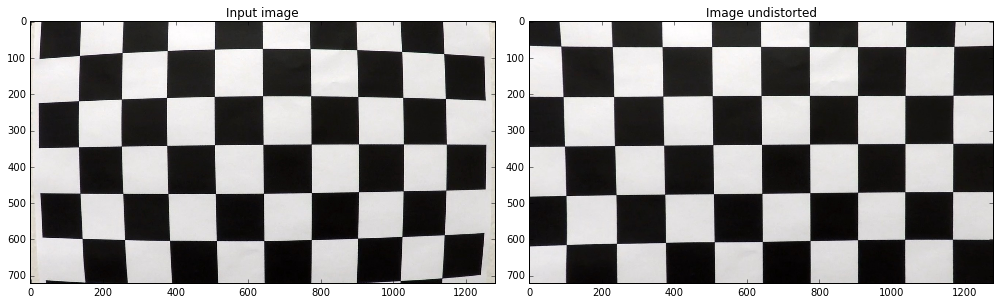

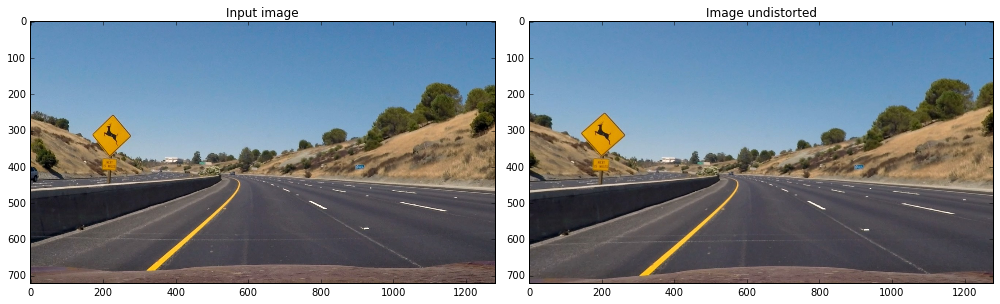

In [95]:
C = CameraCalibration()
# Calibration camera
chess_h = 6
chess_w = 9
C.calibrate('camera_cal/calibration', chess_h, chess_w)

im = cv2.cvtColor(cv2.imread('camera_cal/calibration1.jpg'), cv2.COLOR_BGR2RGB)
im_undistorted = C.undistort(im)
U.pim([im, im_undistorted], ['Input image', 'Image undistorted'])
save_im = cv2.cvtColor(np.concatenate((im, im_undistorted), axis=1), cv2.COLOR_RGB2BGR)
s = cv2.imwrite("undistortion_example.jpg", save_im)

im = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
im_undistorted = C.undistort(im)
U.pim([im, im_undistorted], ['Input image', 'Image undistorted'])
save_im = cv2.cvtColor(np.concatenate((im, im_undistorted), axis=1), cv2.COLOR_RGB2BGR)
s = cv2.imwrite("undistortion_example_2.jpg", save_im)

### Test : Perspective tranformations

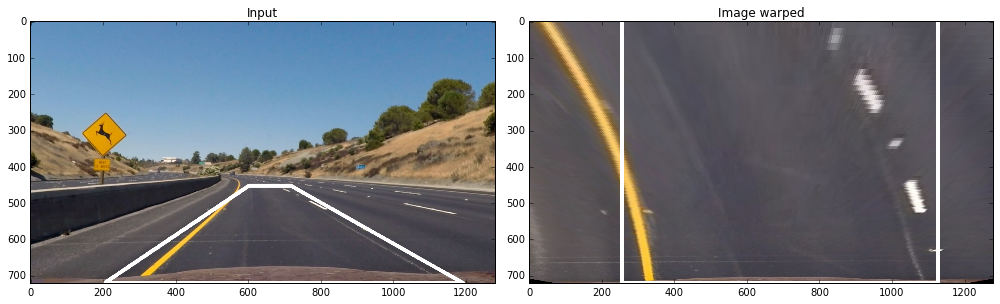

In [96]:
imshape = (720, 1280)
# Cut image a little bit
cut_y = 0.985

# source points for Perspective Transformation
src = np.float32([[imshape[1]*0.47, imshape[0]*0.63],
                 [imshape[1]*0.16, imshape[0]],
                 [imshape[1]*0.93, imshape[0]],
                 [imshape[1]*0.56, imshape[0]*0.63]])

# Destination points for Perspective transformation
dst = np.float32([[(imshape[1] * 0.2), 0],
                 [(imshape[1] * 0.2), imshape[0]],
                 [(imshape[1] * 0.88), imshape[0]],
                 [(imshape[1] * 0.88), 0]])

L = lane_finding(src, dst)
# Creater warped image after Perspective transformation
warped_im = L.warper(im_undistorted)

im_undistorted_ROI = cv2.polylines(np.copy(im_undistorted), [src.astype(np.int32)],
                                   True, (255,255,255), thickness=10)

warped_im_ROI = cv2.polylines(np.copy(warped_im), [dst.astype(np.int32)],
                              True, (255,255,255), thickness=10)

U.pim([im_undistorted_ROI, warped_im_ROI], ['Input', 'Image warped'])

save_im = cv2.cvtColor(np.concatenate((im_undistorted_ROI, warped_im_ROI),
                                      axis=1), cv2.COLOR_RGB2BGR)

s = cv2.imwrite("image_warped.jpg", save_im)

### Test : Color masks and sobel filter. Binary image.

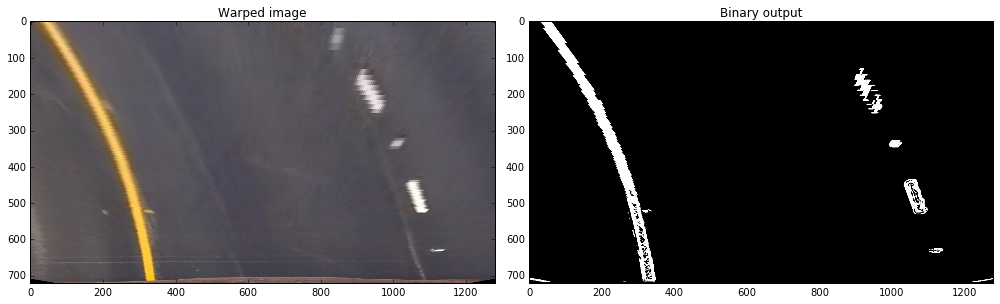

In [97]:
kernel_size = 27
# Iterval for color mask, for yellow color low and high values
yellow_hsv_low  = np.array([0, 65, 165])
yellow_hsv_high = np.array([40, 255, 255])

# Iterval for color mask, for white color low and high values
white_hsv_low  = np.array([18, 0, 170])
white_hsv_high = np.array([255, 80, 255])

B = binary_image(kernel_size = kernel_size)

B.convert_HSV(warped_im)
yellow = B.color_mask(yellow_hsv_low, yellow_hsv_high)
white = B.color_mask(white_hsv_low, white_hsv_high)

# create color mask combo binary image
color_combo = np.zeros_like(yellow)
color_combo[(yellow == 1) | (white == 1)] = 1

B.convert_HLS(warped_im)
warped_sobel_L, warped_sobel_S = B.sobel_mask((90, 160), (90, 160))

# create sobel filter mask combo binary image
sobel_combo = np.zeros_like(warped_sobel_L)
sobel_combo[(warped_sobel_L == 1) | (warped_sobel_S == 1)] = 1

# Combine color binary image together with sobel filter binary image 
combo = np.zeros_like(sobel_combo)
combo[(sobel_combo == 1) | (color_combo == 1)] = 1

U.pim([warped_im, combo], ['Warped image', 'Binary output'])

combo_3ch = np.copy(combo)
combo_3ch[combo_3ch == 1] = 255
combo_3ch = np.dstack((combo_3ch, combo_3ch, combo_3ch))

save_im = cv2.cvtColor(np.concatenate((warped_im, combo_3ch),
                                      axis=1), cv2.COLOR_RGB2BGR)

s = cv2.imwrite("binary_image.jpg", save_im)

### Test : Identify lane-line pixels and fit their positions with a polynomial

(720, 0)

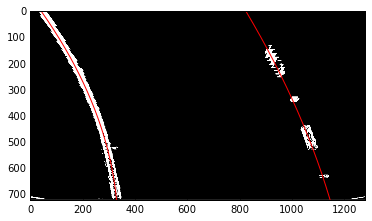

In [98]:
L = lane_finding(src, dst)
L.load_images(combo, im_undistorted)
L.blind_polyfit()
_, left_fit, right_fit, ploty = L.line_points()

plt.imshow(combo_3ch)
plt.plot(left_fit, ploty, color='red')
plt.plot(right_fit, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Test : Calculate curvature of lane and position relative to center of car

Left 390.126361802 Right 794.873609931


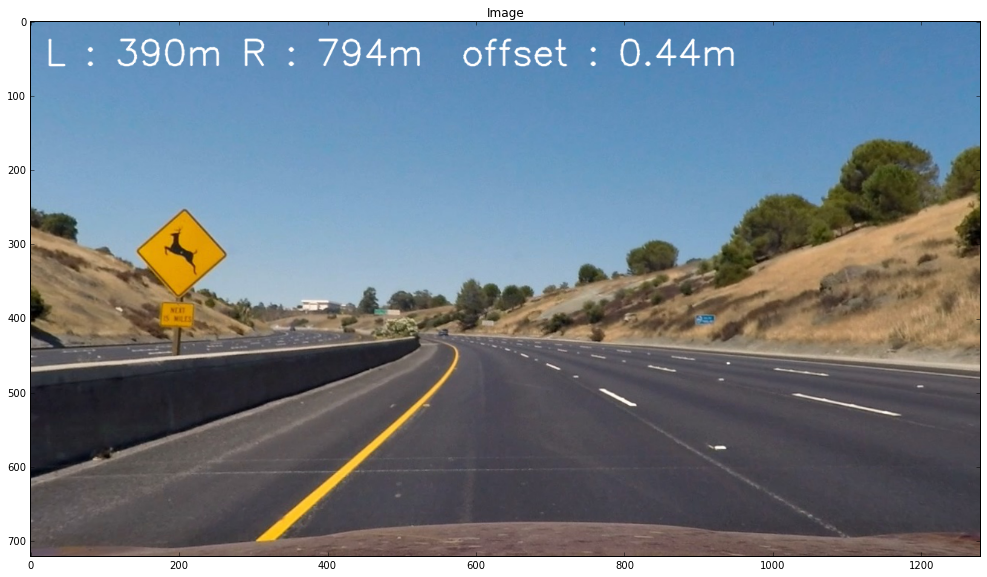

In [99]:
L.curvature()
print('Left', L.left_curverad, 'Right', L.right_curverad)
U.pim([L.color])

s = cv2.imwrite("curverad.jpg", cv2.cvtColor(L.color, cv2.COLOR_RGB2BGR))

# Initialize classes and variables to work with pipeline

In [81]:
# Global values for whole pipeline
imshape = (720, 1280)
im_calib_path = 'camera_cal/calibration'
chess_h = 6
chess_w = 9
kernel_size = 27

# Cut image a little bit
cut_y = 0.985

# Iterval for color mask, for yellow color low and high values
yellow_hsv_low  = np.array([0, 65, 165])
yellow_hsv_high = np.array([40, 255, 255])

# Iterval for color mask, for white color low and high values
white_hsv_low  = np.array([18, 0, 170])
white_hsv_high = np.array([255, 80, 255])

# source points for Perspective Transformation
src = np.float32([[imshape[1]*0.47, imshape[0]*0.63],
                 [imshape[1]*0.16, imshape[0]],
                 [imshape[1]*0.93, imshape[0]],
                 [imshape[1]*0.56, imshape[0]*0.63]])

# Destination points for Perspective transformation
dst = np.float32([[(imshape[1] * 0.2), 0],
                 [(imshape[1] * 0.2), imshape[0]],
                 [(imshape[1] * 0.88), imshape[0]],
                 [(imshape[1] * 0.88), 0]])


# Initilize class values
U = Utils()
B = binary_image(kernel_size = kernel_size)
L = lane_finding(src, dst)
C = CameraCalibration()

# Calibration camera
C.calibrate(im_calib_path, chess_h, chess_w)

In [82]:
def pipeline(im):
    """Pipeline function.
    
    Input : Image
    Output : Image with lanes found + binary image on the right
    
    """
    
    # Undistort image
    im_undistorted = C.undistort(im)
    
    # Cut little bit of buttom which is not needed
    im_undistorted = im_undistorted[0 : int(im_undistorted.shape[0] * cut_y), :]
    
    # Creater warped image after Perspective transformation
    warped_im = L.warper(im_undistorted)
    
    B.convert_HSV(warped_im)
    yellow = B.color_mask(yellow_hsv_low, yellow_hsv_high)
    white = B.color_mask(white_hsv_low, white_hsv_high)
    
    # create color mask combo binary image
    color_combo = np.zeros_like(yellow)
    color_combo[(yellow == 1) | (white == 1)] = 1

    B.convert_HLS(warped_im)
    warped_sobel_L, warped_sobel_S = B.sobel_mask((90, 160), (90, 160))

    # create sobel filter mask combo binary image
    sobel_combo = np.zeros_like(warped_sobel_L)
    sobel_combo[(warped_sobel_L == 1) | (warped_sobel_S == 1)] = 1
    
    # Combine color binary image together with sobel filter binary image 
    combo = np.zeros_like(sobel_combo)
    combo[(sobel_combo == 1) | (color_combo == 1)] = 1

    L.visual(['binary'])
    
    # Load images to lane finding class
    L.load_images(combo, im_undistorted)
    
    # Run and return images with lanes found

    return L.run()

# Let's see how it works on test images

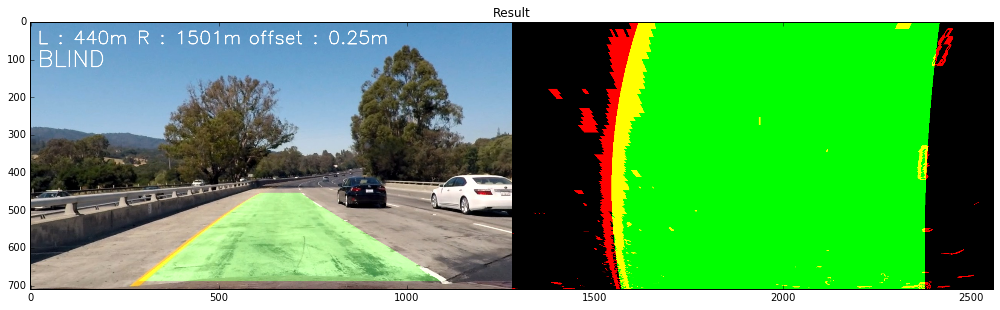

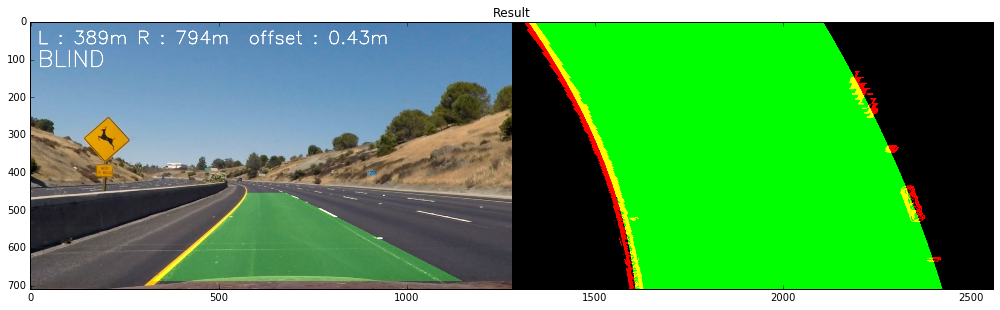

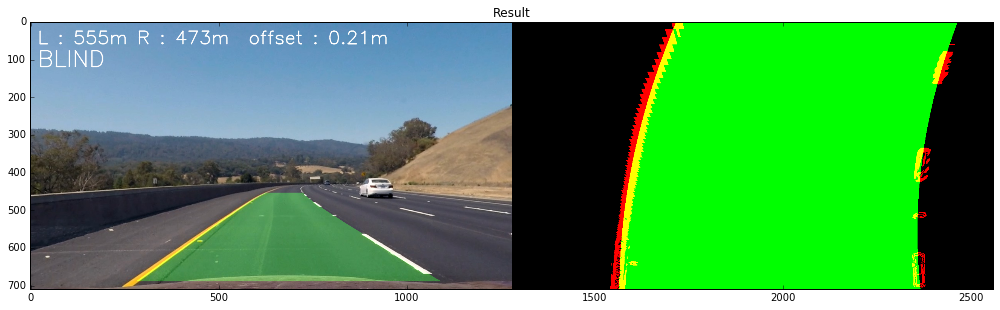

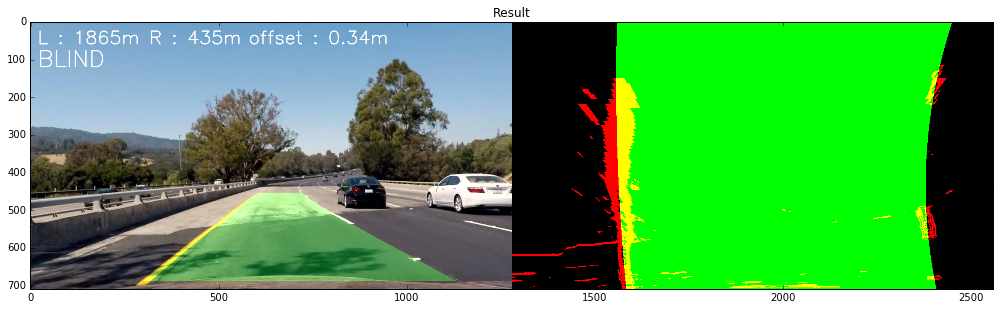

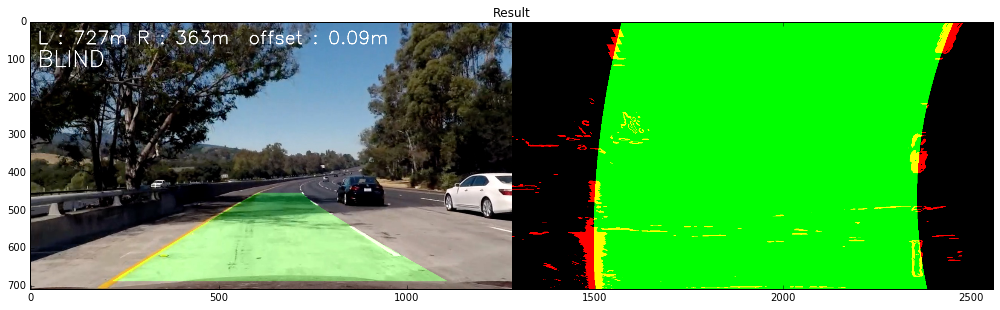

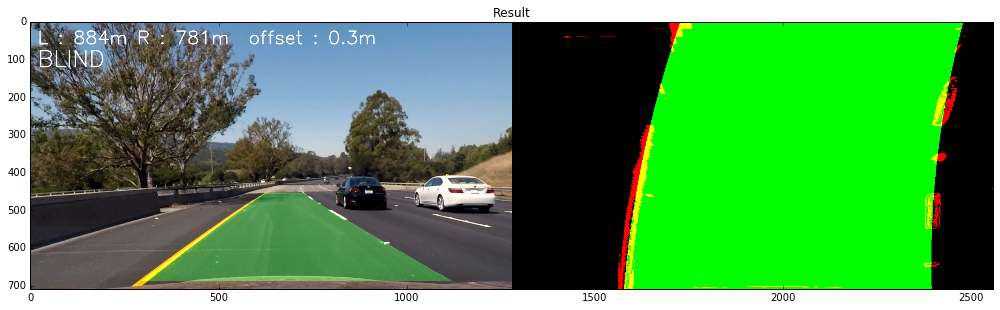

In [100]:
for i in range(1,7):
    im = cv2.cvtColor(cv2.imread('test_images/test{}.jpg'.format(i)), cv2.COLOR_BGR2RGB)
    
    # Need to initilize lane_finding class before start using pipeline otherwise pipeline will use previously saved values
    L = lane_finding(src, dst)
    result = pipeline(im)
    
    U.pim([result], ['Result'])
    s = cv2.imwrite("test_done{}.jpg".format(i), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

In [101]:
# Need to initilize lane_finding class before start using pipeline otherwise pipeline will use previously saved values
L = lane_finding(src, dst)
output = 'project_video_done.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_done.mp4
[MoviePy] Writing video project_video_done.mp4


100%|█████████▉| 1260/1261 [07:31<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_done.mp4 

CPU times: user 18min 3s, sys: 1min 38s, total: 19min 42s
Wall time: 7min 32s
